In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

In [24]:
class EmotionRecognitionModel:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.df = pd.read_csv(csv_file)
        print("\nDescriptive Statistics:")
        print(self.df.describe())
        print("\nDescriptive Statistics:(Categorical)")
        print(self.df.describe(include=["O"]))
        self.features = ['MFCCs']
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def load_data(self):
        # Handle missing values
        self.df = self.df.dropna(subset=self.features + ['Emotion Name'])

        # Convert MFCCs column to arrays of floats
        def parse_mfccs(mfcc_str):
            if isinstance(mfcc_str, str):
                # Remove brackets, commas, and extra spaces
                mfcc_str = mfcc_str.replace('[', '').replace(']', '').replace(',', '').strip()
                # Convert the cleaned string to a float array
                mfcc_array = np.array(mfcc_str.split(), dtype=float)
                return mfcc_array
            return np.array([])  # Handle any non-string cases gracefully

        # Parse MFCCs and check lengths
        mfcc_arrays = self.df['MFCCs'].apply(parse_mfccs)
        max_length = max(len(arr) for arr in mfcc_arrays)
        self.X_mfcc = np.array([np.pad(arr, (0, max_length - len(arr)), mode='constant') for arr in mfcc_arrays])

        # Extract labels
        self.y = self.df['Emotion Name'].values

    def preprocess_data(self):
        # Scale MFCCs features
        self.X_mfcc_scaled = self.scaler.fit_transform(self.X_mfcc)

        # Encode labels
        self.y_encoded = self.label_encoder.fit_transform(self.y)
        self.y_one_hot = to_categorical(self.y_encoded)

        print(self.y_one_hot.shape)
        print(self.X_mfcc_scaled.shape)

    def create_lstm_model(self):
        # Create LSTM model
        model = Sequential()
        model.add(LSTM(units=128, return_sequences=False, input_shape=(1, self.X_mfcc_scaled.shape[1])))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(7, activation='softmax', kernel_regularizer=l2(0.001)))  # Assuming 7 emotion categories
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model = model

    def train_model(self, epochs=50, batch_size=64):
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(self.X_mfcc_scaled, self.y_one_hot, test_size=0.2, random_state=42)
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # Reshape for LSTM input (timesteps = 1)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        # Train model
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], shuffle=True)
        return history

    def evaluate_model(self):
        # Split data for testing
        X_train, X_test, y_train, y_test = train_test_split(self.X_mfcc_scaled, self.y_one_hot, test_size=0.2, random_state=42)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        # Evaluate the model
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f'Test accuracy: {accuracy:.3f}')

    def evaluate_model_with_confusion_matrix(self):
        # Split the data again
        X_train, X_test, y_train, y_test = train_test_split(self.X_mfcc_scaled, self.y_one_hot, test_size=0.2, random_state=42)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        # Get predictions (as probabilities)
        y_pred_probs = self.model.predict(X_test)

        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        report = classification_report(y_true_classes, y_pred_classes, target_names=self.label_encoder.classes_)
        print("Classification Report:\n", report)

        # Compute confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Plot confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.label_encoder.classes_, yticklabels=self.label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def save_model(self, file_path):
        """Save the trained model to the specified file path."""
        self.model.save(file_path)
        # After training, save the scaler
        joblib.dump(self.scaler, 'scaler.pkl')
        np.save('label_encoder_classes.npy', self.label_encoder.classes_)  # Save LabelEncoder classes
        print(f"Model and LabelEncoder saved to {file_path} and label_encoder_classes.npy")

In [22]:
def plot_model_performance(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [25]:
model = EmotionRecognitionModel('Merged_CSV.csv')


Descriptive Statistics:
        Pitch Mean       Energy   Formant F1   Formant F2   Formant F3  \
count  2797.000000  1219.000000  1219.000000  1219.000000  1219.000000   
mean   1310.957506     0.018065   458.433931  1882.139215  2817.282547   
std     319.737659     0.006499   133.687191   529.589510   351.798474   
min     438.982392     0.003949   187.613873   551.728140  1897.671346   
25%    1106.476481     0.013642   384.922376  1499.520499  2596.635444   
50%    1289.161222     0.017059   453.405842  1860.098004  2755.594572   
75%    1517.406480     0.021325   512.574985  2231.143910  2979.554613   
max    2293.496532     0.049453  1811.248701  3125.078030  4319.623639   

       Speech Rate  Zero Crossing Rate  
count  1219.000000         1219.000000  
mean      0.280126            0.114832  
std       0.054337            0.030462  
min       0.168067            0.043862  
25%       0.230549            0.096072  
50%       0.281690            0.114519  
75%       0.320000   

In [13]:
model.load_data()
model.preprocess_data()
model.create_lstm_model()

(2797, 7)
(2797, 40)


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
history = model.train_model()

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3040 - loss: 1.8633 - val_accuracy: 0.8500 - val_loss: 1.3750
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7049 - loss: 1.2311 - val_accuracy: 0.9196 - val_loss: 0.5120
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8282 - loss: 0.6003 - val_accuracy: 0.9786 - val_loss: 0.1884
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9142 - loss: 0.3330 - val_accuracy: 0.9875 - val_loss: 0.0950
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9382 - loss: 0.2359 - val_accuracy: 0.9911 - val_loss: 0.0634
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9560 - loss: 0.1828 - val_accuracy: 0.9929 - val_loss: 0.0498
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.1502 - val_accuracy: 0.9893 - val_loss: 0.0443
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9694 - loss: 0.1182 - val_accuracy: 0.9929 - val_loss

In [15]:
model.evaluate_model()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0561 
Test accuracy: 0.996


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report:
                    precision    recall  f1-score   support

            angry       1.00      1.00      1.00        75
          disgust       1.00      1.00      1.00        92
             fear       1.00      1.00      1.00        75
            happy       0.98      1.00      0.99        83
          neutral       1.00      1.00      1.00        81
pleasant_surprise       1.00      0.98      0.99        82
              sad       1.00      1.00      1.00        72

         accuracy                           1.00       560
        macro avg       1.00      1.00      1.00       560
     weighted avg       1.00      1.00      1.00       560



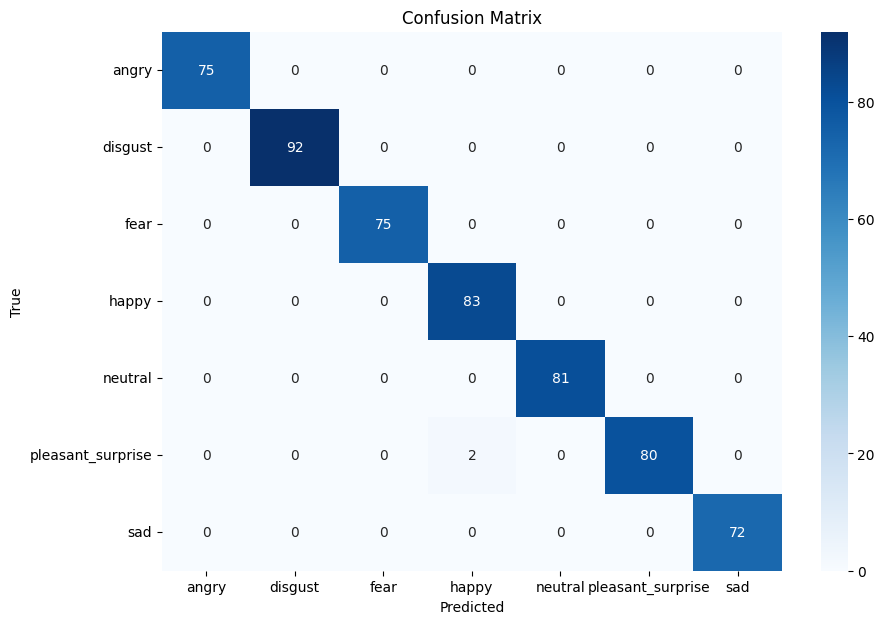

In [16]:
model.evaluate_model_with_confusion_matrix()

In [17]:
model.save_model('emotion_recognition_model.h5')

Model and LabelEncoder saved to emotion_recognition_model.h5 and label_encoder_classes.npy


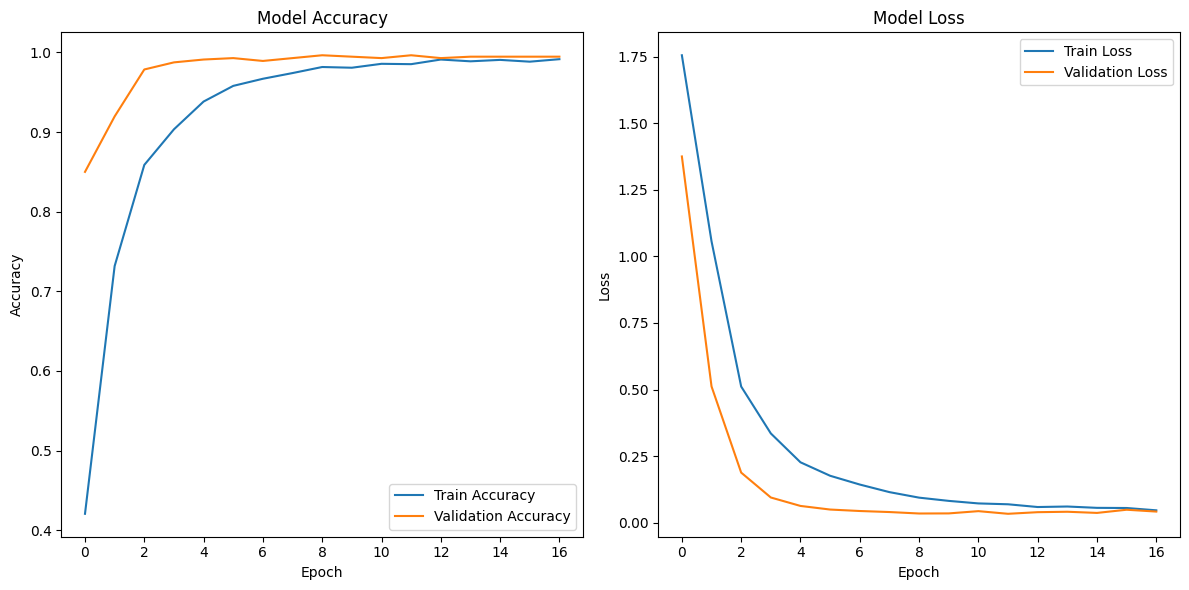

In [18]:
plot_model_performance(history)